In [11]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [12]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [13]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O ./sunspots.csv

--2020-09-11 22:30:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.176, 172.217.15.80, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘./sunspots.csv’

./sunspots.csv      100%[===================>]  69.17K   444KB/s    in 0.2s    

2020-09-11 22:30:59 (444 KB/s) - ‘./sunspots.csv’ saved [70827/70827]



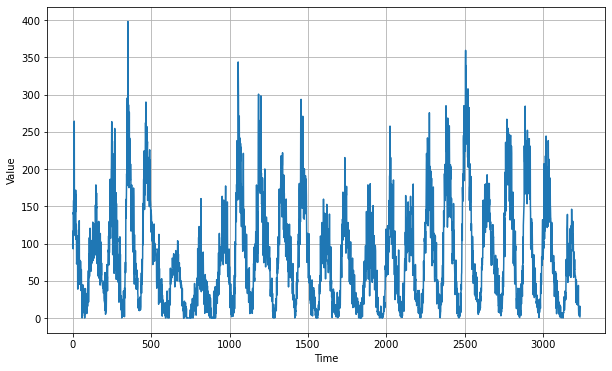

In [14]:
import csv
time_step = []
sunspots = []

with open('./sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [15]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # sequence-to-vector
    return dataset.batch(batch_size).prefetch(1)
    

In [28]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
92/92 [==============================] - 0s 5ms/step - loss: 6258.3281
Epoch 2/100
92/92 [==============================] - 0s 4ms/step - loss: 1267.9070
Epoch 3/100
92/92 [==============================] - 0s 4ms/step - loss: 1004.6877
Epoch 4/100
92/92 [==============================] - 0s 4ms/step - loss: 930.3992
Epoch 5/100
92/92 [==============================] - 0s 5ms/step - loss: 876.3593
Epoch 6/100
92/92 [==============================] - 0s 4ms/step - loss: 846.1988
Epoch 7/100
92/92 [==============================] - 0s 4ms/step - loss: 803.5134
Epoch 8/100
92/92 [==============================] - 0s 5ms/step - loss: 780.4027
Epoch 9/100
92/92 [==============================] - 0s 4ms/step - loss: 755.3937
Epoch 10/100
92/92 [==============================] - 0s 5ms/step - loss: 741.0422
Epoch 11/100
92/92 [==============================] - 0s 4ms/step - loss: 726.3795
Epoch 12/100
92/92 [==============================] - 0s 4ms/step - loss: 717.2104
Epoch 13/1

92/92 [==============================] - 0s 4ms/step - loss: 579.7055
Epoch 100/100
92/92 [==============================] - 0s 4ms/step - loss: 578.9304


In [29]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

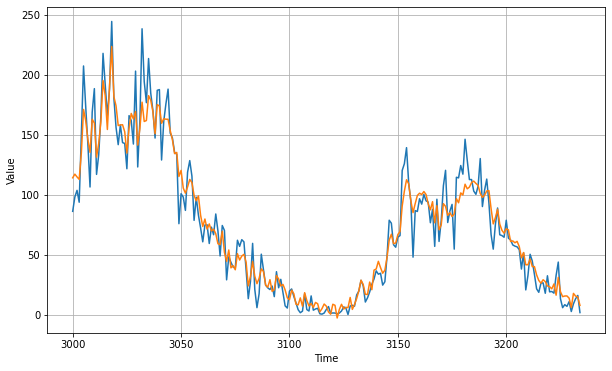

In [30]:
forecast = model_forecast(model, series, window_size)
forecast = forecast[split_time-window_size+1:]
results = np.array(forecast)[:, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [31]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

9.731144